In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

## PyTorch Neural Network Classification

In [2]:
# we're going to use scikit-learn's make_circle dataset to generate circles with different colored dots

# defining how many samples we need
n_samples = 1000

# creating circles using dataset
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
# checking shape of X and y
len(X), len(y)

(1000, 1000)

In [4]:
# let's check first 5 values of X and y
print(f'X:{X[:5]}')
print(f'y:{y[:5]}')

# make_circle datasets in our case is used for binary classification
# so y has only 1 and 0 as outputs

X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
y:[1 1 1 1 0]


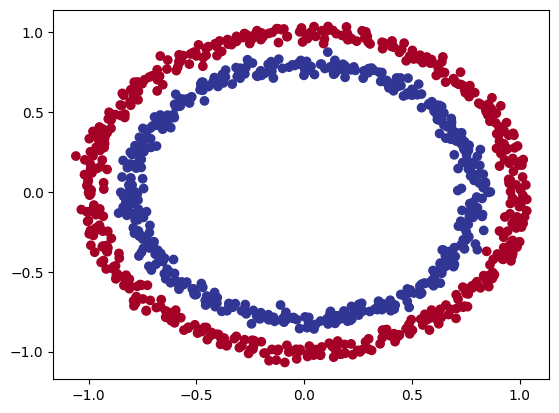

In [5]:
# let's visualize data
# don't forget that X's 1st column is x and 2nd clumn
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y, # c takes value 1 or 0 from y so it can define color of dots
            cmap=plt.cm.RdYlBu)

In [6]:
print(type(X), type(y))

# turning data into tensors so PyTorch can work with them
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples and data type of X and y
print(X[:5], y[:5])
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [7]:
# in scikit-learn we have train_test_split function to randomly split our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# test_size takes float as argument and 0.2 means 20% will be randomly taken for testing data
# random_state means random seed

In [8]:
# checking shape of train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# 20% form 1000 which is equeal to 200 was given for test data

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [9]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# let's construct model which takes inputs as X and gives outputs as y in our case
class CircleModelV0(nn.Module): # almost every PyTorch model is subclass of nn.Module
  def __init__(self):
    super().__init__()
    # we're creating 2 layers which are connected to each other as X -> layer1 -> layer2 -> y
    self.layer1 = nn.Linear(in_features=2, out_features=5) # 1st layer which takes 2 featuers(X) and passes 5 features to layer2
    self.layer2 = nn.Linear(in_features=5, out_features=1) # 2nd layer which takes 5 features of layer1 and outputs 1 feature(y)

  def forward(self, x): # here we are passing values of layer1(takes X) to layer2(returns y)
    return self.layer2(self.layer1(x))

# creating instance of CircleModelV0 by defining on which device it should work
model_0 = CircleModelV0().to(device) # here device is equeal to 'cuda'
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# making predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0467],
        [-0.1554],
        [ 0.0932],
        [-0.0858],
        [-0.1367],
        [-0.2013],
        [-0.3249],
        [-0.3363],
        [ 0.1027],
        [-0.1652]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [12]:
# in this code cell we're just checking what torch.eq().sum() returns

a = torch.tensor([1, 2, 3, 4])
b = torch.tensor([1, 0, 3, 4])

# Comparison
comparison = torch.eq(a, b)  # Compares element-wise, returns a boolean tensor

# Count the number of True values
count_true = comparison.sum()

print("Comparison:", comparison)
print("Count of True values:", count_true.item())  # Convert to Python int

Comparison: tensor([ True, False,  True,  True])
Count of True values: 3


In [13]:
# in this code cell we're just checking how to represent boolean values of tensor as integer(1 and 0)

# Example tensor with boolean values
bool_tensor = torch.tensor([True, False, True, False])

# Convert boolean tensor to tensor of 1s and 0s
int_tensor = bool_tensor.int()

# Convert integer(1 and 0) tensor to boolean tensor
new = int_tensor.bool()

print("Boolean tensor:", bool_tensor)
print("Integer tensor:", int_tensor) # torch.Tensor.int() used for converting
print("Boolean tensor from Integer Tensor:", new) # torch.Tensor.bool() used for converting

Boolean tensor: tensor([ True, False,  True, False])
Integer tensor: tensor([1, 0, 1, 0], dtype=torch.int32)
Boolean tensor from Integer Tensor: tensor([ True, False,  True, False])


## Setup loss and optimizer functions

In [14]:
# loss function
# we're using nn.BCEWithLogitsLoss because we want to calculate loss of binary classification problem
loss_fn = nn.BCEWithLogitsLoss() # nn.BCEWithLogitsLoss comes with sigmoid built-in

# optimizer
optim = torch.optim.SGD(params=model_0.parameters(),
                        lr=0.1)

In [15]:
# let's calculate how accurate our model is
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
## Working with raw logits
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits
# logits are raw numbers which are untrained and came random from forward()

tensor([[-0.0467],
        [-0.1554],
        [ 0.0932],
        [-0.0858],
        [-0.1367]], device='cuda:0')

In [17]:
# because raw logits are hard to interpret we're are going to usen activation function

# turning raw logits to prediction probabilities using torch.sigmoid()
y_pred_probs = torch.sigmoid(y_logits)

y_pred_probs # these numbers are slightly different from raw logits

tensor([[0.4883],
        [0.4612],
        [0.5233],
        [0.4786],
        [0.4659]], device='cuda:0')

In [18]:
# let's find actual output(prediction labels) of our model
y_preds = torch.round(y_pred_probs)
# we're using round() to find which output our model gives after all operations
# in other words we're rounding our prediction probabilities for actual output
# if y_pred_probs >= 0.5 -> y=1
# if y_pred_probs < 0.5 -> y=0

y_preds

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0')

In [19]:
# we can simplify our steps which we have done above
y_preds_simplified = torch.round(torch.sigmoid(model_0(X_test.to(device)))[:5])

y_preds_simplified # the same as y_preds because steps are the same

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

## Training and Testing loop

In [20]:
# Set manual seed for cuda
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# TRAINING
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze() # squeeze() is used to ged rid off extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optim.zero_grad()

  loss.backward()

  optim.step()

  model_0.eval()
  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # 2. Caculate loss/accuracy
      test_loss = loss_fn(test_logits,
                          y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69797, Accuracy: 47.75% | Test loss: 0.69343, Test acc: 51.00
Epoch: 10 | Loss: 0.69687, Accuracy: 47.75% | Test loss: 0.69274, Test acc: 52.00
Epoch: 20 | Loss: 0.69611, Accuracy: 48.38% | Test loss: 0.69235, Test acc: 52.50
Epoch: 30 | Loss: 0.69554, Accuracy: 48.12% | Test loss: 0.69213, Test acc: 52.00
Epoch: 40 | Loss: 0.69510, Accuracy: 48.88% | Test loss: 0.69202, Test acc: 52.00
Epoch: 50 | Loss: 0.69475, Accuracy: 48.75% | Test loss: 0.69199, Test acc: 53.00
Epoch: 60 | Loss: 0.69447, Accuracy: 48.62% | Test loss: 0.69200, Test acc: 52.50
Epoch: 70 | Loss: 0.69424, Accuracy: 48.50% | Test loss: 0.69204, Test acc: 52.00
Epoch: 80 | Loss: 0.69405, Accuracy: 48.50% | Test loss: 0.69211, Test acc: 52.00
Epoch: 90 | Loss: 0.69389, Accuracy: 48.62% | Test loss: 0.69219, Test acc: 51.50


In [21]:
# lets's visualize how our model are doing well
# for that we'll use some useful functions for visualizing from github repo

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") # getting source code from github repo
  with open("helper_functions.py", "wb") as f:
    f.write(request.content) # here we're creating new file named helper_functions.py and save it

from helper_functions import plot_predictions, plot_decision_boundary

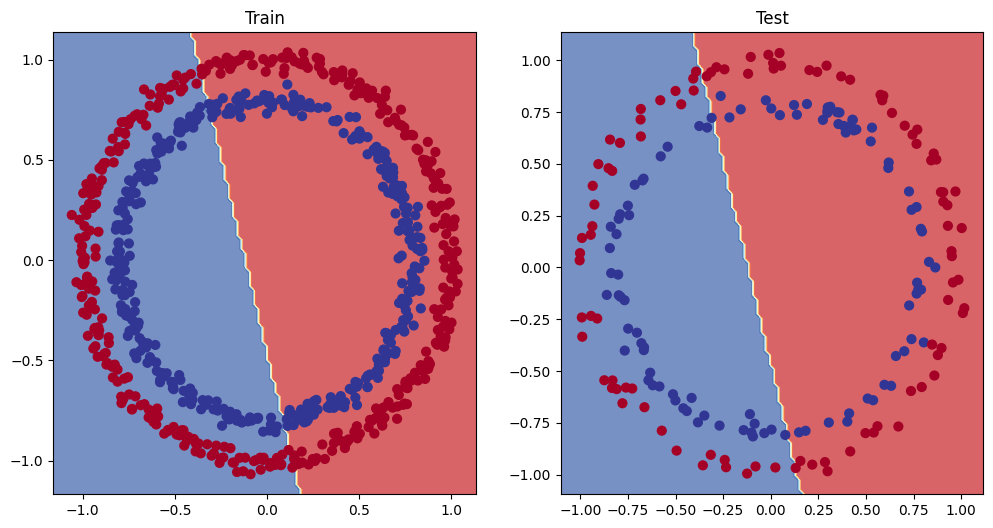

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # 1st subplot for train data
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test") # 2nd subplot for test data
plot_decision_boundary(model_0, X_test, y_test)

## Improving Model (hint: it will not work😔, so it will be skiped)

In [23]:
# now let's improve code oof our model by changing hyperparameters
# hyperparameters are parameters(epochs, number of layers, etc.) which are defined by ourselves
# model(class) below is new redefined and improved version of our old model CircleModelV0
class CircleModelV1(nn.Module):
  def __init__(self):
   super().__init__()
   self.layer_1 = nn.Linear(in_features=2, out_features=10)
   self.layer_2 = nn.Linear(in_features=10, out_features=10)
   self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x))) # it's faster option of code above

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [25]:
# it this code cell we wanted to implement training and testing loop of our model CircleModelV1
# but unfortunately out model can't learn dataset of sci-kitlearn
# so we have decided to skip training and testing
# main reason why it can't learn is that linear functions are not able to learn dataset we have

## What is ReLU

In [26]:
# let's see what rectified linear activation or ReLU
def rectified(x):
 return max(0.0, x)

# demonstrate with a positive input
x = 1.0
print('rectified(%.1f) is %.1f' % (x, rectified(x)))
x = 1000.0
print('rectified(%.1f) is %.1f' % (x, rectified(x)))
# demonstrate with a zero input
x = 0.0
print('rectified(%.1f) is %.1f' % (x, rectified(x)))
# demonstrate with a negative input
x = -1.0
print('rectified(%.1f) is %.1f' % (x, rectified(x)))
x = -1000.0
print('rectified(%.1f) is %.1f' % (x, rectified(x)))

rectified(1.0) is 1.0
rectified(1000.0) is 1000.0
rectified(0.0) is 0.0
rectified(-1.0) is 0.0
rectified(-1000.0) is 0.0


## Making new model with non-linearity (hint: it will work😊)

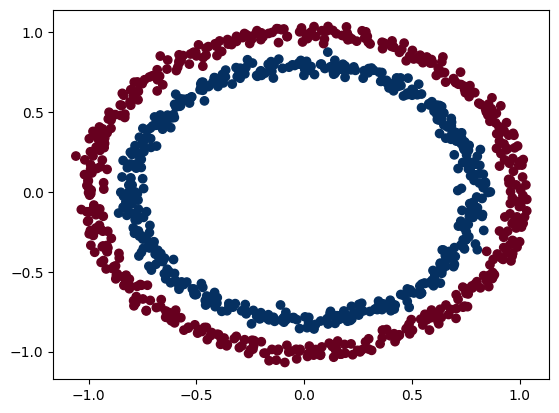

In [27]:
# Make and plot data againg for another model and its training
n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [28]:
# Convert to tensors and split into train and test sets
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [29]:
# let's create another model whihch have some non-linear functions
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # as we can notice, there are the same layers which we have in our last model CircleModelV1 but with one non-linear avtivation layer(ReLU)
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    # here we applied ReLU to every single layer

model_2 = CircleModelV2().to(device)
print(model_2)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
# optimizer and loss functions are the same as for 2 previous models
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model_2.parameters(),
                        lr=0.1)

In [31]:
# let's tarin and test our new model (hint: training tesing steps are the same as always)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000 + 1 # sometimes to improve our model we may need more epochs for better learning

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# TRAINING
for epoch in range(epochs):
  model_2.train()

  # forwar pass
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # optimizer zero grad
  optim.zero_grad()

  # backward prop
  loss.backward()

  # optimizer step
  optim.step()

  # TESTING
  model_2.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69763, Accuracy: 50.00% | Test Loss: 0.69818, Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69103, Accuracy: 50.25% | Test Loss: 0.69133, Test Accuracy: 50.00
Epoch: 200 | Loss: 0.68936, Accuracy: 57.38% | Test Loss: 0.68886, Test Accuracy: 55.50
Epoch: 300 | Loss: 0.68744, Accuracy: 54.87% | Test Loss: 0.68626, Test Accuracy: 53.50
Epoch: 400 | Loss: 0.68504, Accuracy: 53.37% | Test Loss: 0.68367, Test Accuracy: 54.00
Epoch: 500 | Loss: 0.68199, Accuracy: 58.13% | Test Loss: 0.68028, Test Accuracy: 59.50
Epoch: 600 | Loss: 0.67833, Accuracy: 60.12% | Test Loss: 0.67608, Test Accuracy: 64.00
Epoch: 700 | Loss: 0.67321, Accuracy: 59.50% | Test Loss: 0.67145, Test Accuracy: 62.00
Epoch: 800 | Loss: 0.66732, Accuracy: 59.38% | Test Loss: 0.66545, Test Accuracy: 62.50
Epoch: 900 | Loss: 0.65976, Accuracy: 60.00% | Test Loss: 0.65771, Test Accuracy: 63.50
Epoch: 1000 | Loss: 0.64866, Accuracy: 61.75% | Test Loss: 0.64766, Test Accuracy: 65.50


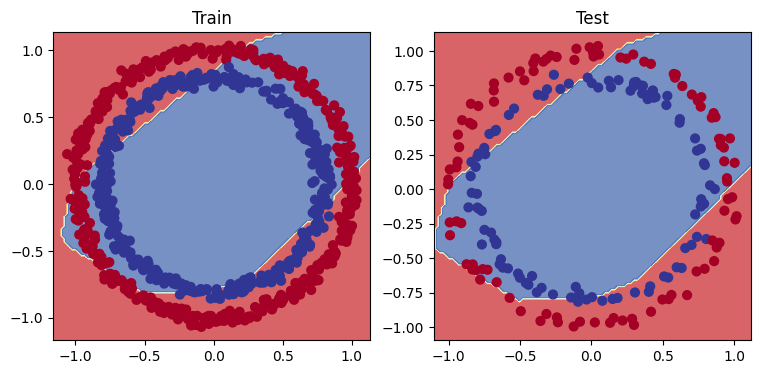

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

## ReLU and Sigmoid functions

In [33]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)
  # difference between torch.max() and torch.maximum() is that
  # torch.maximum() returns computes the element-wise maximum of given number and tensor
  # while torch.max() returns the maximum value of all elements in the input tensor

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

## How function can return multiple values and assign them to more than one variable

In [34]:
def my_function():
    value1 = "Hello"
    value2 = "World"
    return value1, value2

result1, result2 = my_function()
print(result1)  # Output: Hello
print(result2)  # Output: World

Hello
World


In [35]:
def my_function1():
    value1 = "Hello"
    value2 = "World"
    return value1, value2

result1 = my_function1()
print(result1)  # Output: ('Hello', 'World')
print(result1[0])  # Output: Hello
print(result1[1])  # Output: World

('Hello', 'World')
Hello
World


## Multiclass classification